In [3]:
import numpy as np
import healpy
import hpm
import sim
from astropy.time import Time
import aipy
import tqdm
import glob

import matplotlib.pyplot as plt
%matplotlib widget

ModuleNotFoundError: No module named 'jax'

In [4]:
!pip install jax

  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 1.2 MB/s  0:00:021.1 MB/s eta 0:00:01:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 MB 8.6 MB/s  0:00:09 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 13.7 MB/s  0:00:005.3 MB/s eta 0:00:01
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [jax]━━━━━━━ 3/4 [jax]ib]es]


In [ ]:
METADATA_FILE = 'beam_constraint_metadata.npz'
with np.load(METADATA_FILE) as npz:
    freqs = npz['freqs']
    times = npz['times']
    azalts = npz['azalts']
real_dtype = np.float32
complex_dtype = np.complex64

In [ ]:
#DATA_FILE = 'sim_v003.npz'
#def get_metadata(filename, real_dtype=real_dtype):
#    with np.load(filename) as npz:
#        freqs = npz['freqs']
#        times = npz['times']
#        azalts = npz['azalts']
#    return dict(freqs=freqs, times=times, azalts=azalts)

In [ ]:
#metadata = get_metadata(DATA_FILE)
#freqs = metadata['freqs'][::2]
#times = metadata['times']
#azalts = metadata['azalts']

In [ ]:
#np.savez('beam_constraint_metadata.npz', freqs=freqs, times=times, azalts=azalts)

In [ ]:
beam = sim.Beam(freqs)
#terrain = sim.Terrain(freqs, transmitters=[])
#terrain_mask = np.where(np.isnan(terrain.map), 1.0, 0.0)
#gsim = sim.GlobalSim(Time(times, format='jd'), freqs, beam, terrain)
#gsim.set_sky_model(weights={'gsm': 1.0, 'points': 0.0})
T21cm = sim.load_T21cm_models(freqs)

For
\begin{equation}
T_{sky}(\nu, \hat s_{eq})=\sum_{\ell,m} a_{\ell,m}(\nu) Y^\ell_m(\hat s_{eq}, \nu)
\end{equation}
expressed for $\hat s_{eq}$ being equatorial coordinates, then the modes of $T_{sky}$ that do not change position with respect to an antenna in topocentric coordinates are those that are axis-symmetric around the $\hat z$ axis---namely the $m=0$ modes.

Below, we examine these components of the Global Sky Model (GSM) to affirm that they exhibit the usual $\nu^{-2.5}$ spectral index scaling (spoiler: they do).

In [ ]:
#LMAX = 30
#alms = np.empty((LMAX+1, freqs.size), dtype=complex_dtype)
#for ch in range(freqs.size):
#    alms[:, ch] = healpy.map2alm(gsim.sky_model[:, ch], lmax=LMAX)[:LMAX+1]  # grab only m=0 modes

In [ ]:
#plt.figure(figsize=(8, 4))
#plt.loglog(freqs / 1e6, np.abs(alms.T))
#plt.loglog(freqs / 1e6, 180 * (freqs / 180e6)**-2.5, 'k:')
#plt.title('Spectrum of GSM $m=0$ modes')
#plt.xlabel('Frequency [MHz]')
#plt.ylabel('T [K]')
#plt.ylim(1e-1, 1e5)
#None

These are the modes that are in danger of being attributed to a monopole sky term by any fit, as they do not exhibit any time variation with respect to an antenna beam. Since they all exhibit approximately the same spectrum, we could effectively model these terms as a uniform temperature power law above the horizon: $T(\nu)\sim T_0 (\nu / \nu_0)^{-2.5}$

An antenna will also see a ground temperature, which we will assume is flat in frequency, and not time dependent. Thus, we can imagine modeling everything below the horizon with a constant $T_{gnd}$. We will also see sky scattering off of the ground, but we are going to save the discussion of that component for later, where we show that, for a sufficient air gap between the antenna and the terrain, this term can be effectively removed without impacting the recovery of cosmological 21cm signals. As a result, the temperature field our antenna sees is effectively:
\begin{equation}
T(\nu, \hat s_{top}) = 
\begin{cases}
    T_{sky}(\nu, R_{eq\rightarrow top}\hat s_{eq}),& \text{if } s_{top,z} > 0\\
    T_{gnd},              & \text{otherwise}\\
\end{cases}
\end{equation}

In our experiment, we attempt to distinguish the contributions of the sky and the ground (as well as any other anisotropic sky/ground temperature terms) by rotating our beam in altitude and azimuth. We will assume our beam does not change as we rotate, so that, in beam coordinates (with $\hat z$ pointed along the boresight of the antenna), the beam is unaffected by alt and az.

In this approximation, rotation changes the projection of $Y^\ell_m(\hat s_{top})$ onto $Y^\ell_m(\hat s_{bm})$ beam modes, and the $Y^\ell_m$ modes of the ground plus sky have a long bessel-like tail toward larger $\ell$ from the horizon discontinuity. As a result, the primary way that our antenna will pick up the sky monopole is actually through a dipole term in our antenna temperature. For example, a way to extact the sky monopole would be to rotate our antenna through $2\pi$ radians in altitude and look for a signal that exhibits this same period and is in-phase with the projection of $\hat s_{bm}$ along $s_{top, z}$. Terms that modulate faster than this must come from $\ell > 1$ modes, either in the beam or from the sky, and can be isolated from a reconstructed monopole signal in the limit of many measurements distributed over all rotations.

However, a systematic that could be particularly pernicious would be a beam dipole term that, when illuminated by the sky + ground temperature anisotropy described above, imprints features in the integrated spectrum that resemble a 21cm cosmological signal. This dipole term would exhibit the same period of variation versus beam rotation that the bona fide 21cm monopole would, and even a small beam component, when illuminated by the bright foreground and ground temperatures, would likely exceed the cosmological signal. Moreover, errors in pointing and horizon modeling would make it difficult to reject these terms on the basis of phase relative to $\hat s_{bm}$ relative to $s_{top, z}$.

As a result, it is unlikely that we could trust cosmological modes that share spectral shapes with variations that appear with a $2\pi$ period over beam rotations inside of a sky + ground model.
As discussed above, a sufficient sky + ground model would probably be a simple $T_0(\nu / \nu_0)^{-2.5}$ sky spectrum where $s_{top,z}>0$, and a uniform $T_{gnd}$ below that.

In [10]:
import jax
import jax.numpy as jnp

npix = beam.map.shape[0]
crds = np.array(healpy.pix2vec(ipix=np.arange(npix), nside=beam.nside()))
NALTS = 16
NBATCH = 64
alts = np.linspace(0, 2*np.pi, NALTS, endpoint=False)
Tsky = 180 * (freqs / 180e6)**-2.5
Tgnd = 300.0

#filenames = ['eigsep_bowtie_v000.npz', 'eigsep_reflector_bowtie_v000.npz', 'eigsep_vivaldi.npz', 'ideal_direct']
filenames = sorted(glob.glob('Bended_*[04].npz'))
print(filenames)
nbeams = len(filenames)
beam_maps = np.empty((nbeams, npix, freqs.size), dtype=real_dtype)
for i, f in enumerate(filenames):
    if f.endswith('npz'):
        beam_maps[i] = sim.load_beam(freqs, f)
    elif f == 'ideal_direct':
        beam_maps[i] = np.where(crds[2] > 0, 1.0, 0.0)[:, None] * np.ones_like(freqs)[None, :]
spec = np.empty((nbeams, NALTS, freqs.size), dtype=real_dtype)
spec_modes = np.empty((nbeams, 2*NBATCH, freqs.size), dtype=complex_dtype)

@jax.jit
def split_beam_up_down(R, crds, beam_maps):
    tz = R[2].dot(crds)
    beam_up = jnp.sum((tz[None, :, None] > 0) * beam_maps, axis=1)
    beam_dn = jnp.sum((tz[None, :, None] <= 0) * beam_maps, axis=1)
    return beam_up, beam_dn

for b, az in tqdm.tqdm(enumerate(np.random.uniform(0, 2*np.pi, size=NBATCH)), total=NBATCH):
    vec = np.array([np.sin(az), np.cos(az), 0])
    Tsky = np.random.uniform(180, 400) * (freqs / 180e6)**np.random.uniform(-2.6, -2.4)
    for i, alt in enumerate(alts):
        R = aipy.coord.rot_m(alt, vec)
        beam_up, beam_dn = split_beam_up_down(R, crds, beam_maps)
        spec[:, i, :] = (beam_up * Tsky + beam_dn * Tgnd) / (beam_up + beam_dn)
    spec_modes[:, 2*b:2*b+2, :] = np.fft.fft(spec, axis=1)[:, 0:2, :] # 2 pi periodic mode

['Bended_Antenna_Results_Angle_+0.npz', 'Bended_Antenna_Results_Angle_+10.npz', 'Bended_Antenna_Results_Angle_+14.npz', 'Bended_Antenna_Results_Angle_+20.npz', 'Bended_Antenna_Results_Angle_+24.npz', 'Bended_Antenna_Results_Angle_+30.npz', 'Bended_Antenna_Results_Angle_+34.npz', 'Bended_Antenna_Results_Angle_+4.npz', 'Bended_Antenna_Results_Angle_+40.npz', 'Bended_Antenna_Results_Angle_+44.npz', 'Bended_Antenna_Results_Angle_+50.npz', 'Bended_Antenna_Results_Angle_-10.npz', 'Bended_Antenna_Results_Angle_-14.npz', 'Bended_Antenna_Results_Angle_-20.npz', 'Bended_Antenna_Results_Angle_-24.npz', 'Bended_Antenna_Results_Angle_-30.npz', 'Bended_Antenna_Results_Angle_-4.npz']


100%|███████████████████████████████████████████| 64/64 [05:38<00:00,  5.28s/it]


In [11]:
U, S, V = np.linalg.svd(spec_modes, full_matrices=False)
idx = []
for i in range(nbeams):
    idx.append(S[i].size - np.searchsorted(S[i,::-1], S[i,0] / 1e5))

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


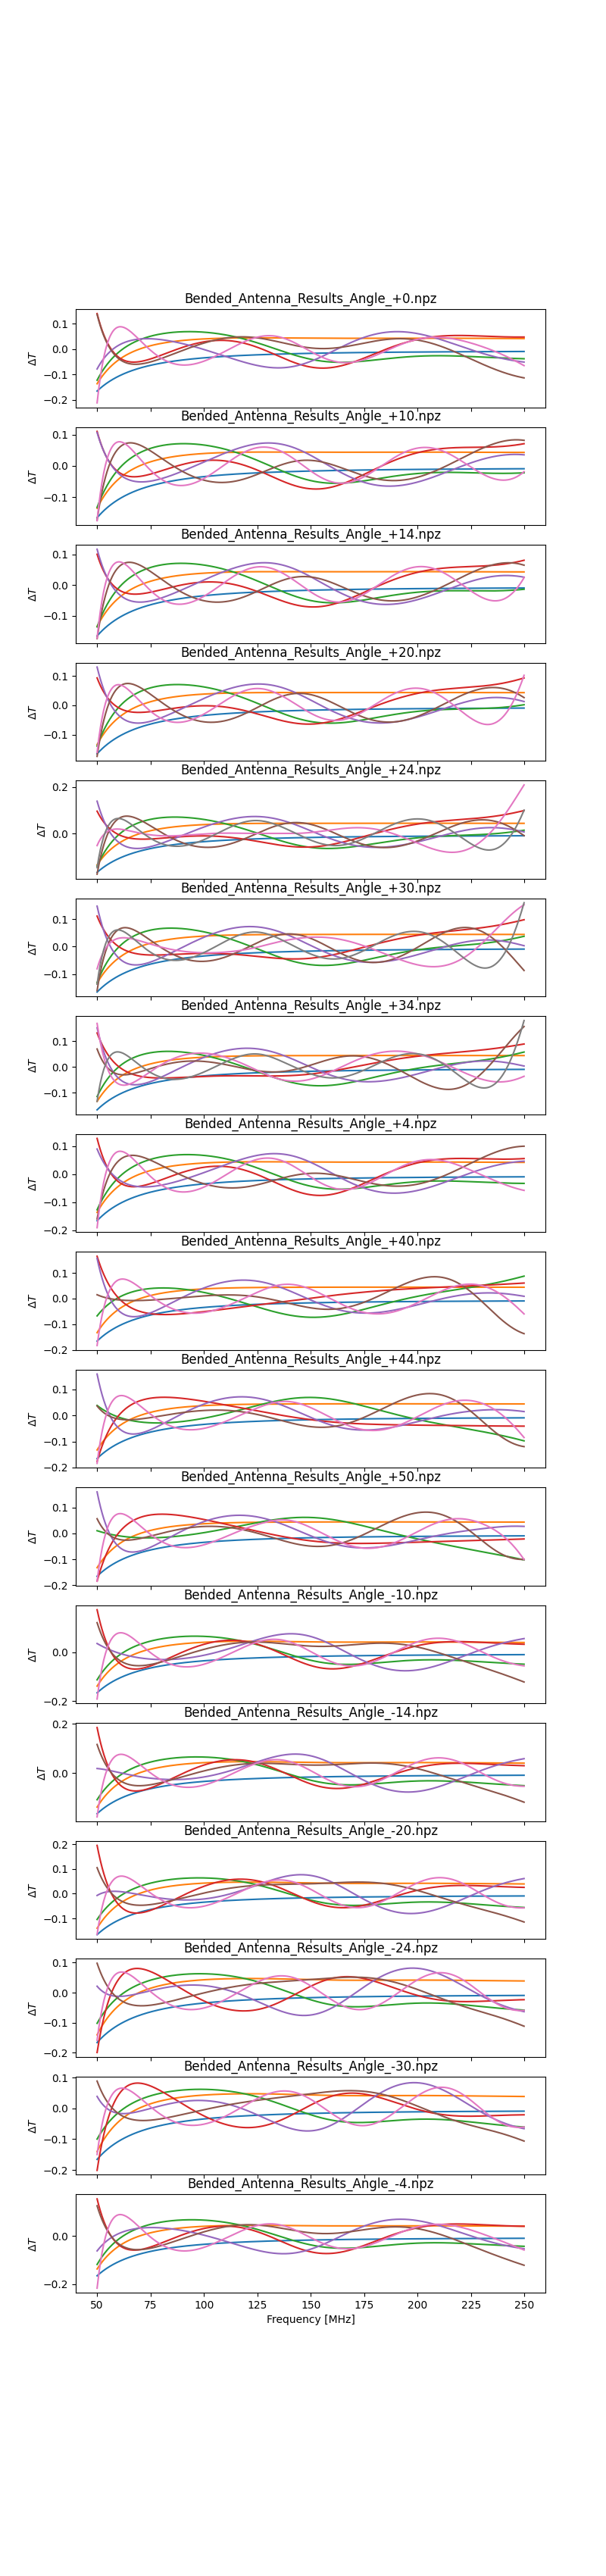

In [12]:
fig, axes = plt.subplots(nrows=nbeams, sharex=True, figsize=(8,2*nbeams))
for i in range(nbeams):
    axes[i].plot(freqs / 1e6, V[i,:idx[i]].T)
    axes[i].set_title(filenames[i])
    axes[i].set_ylabel('$\Delta T$')
axes[-1].set_xlabel('Frequency [MHz]')
None

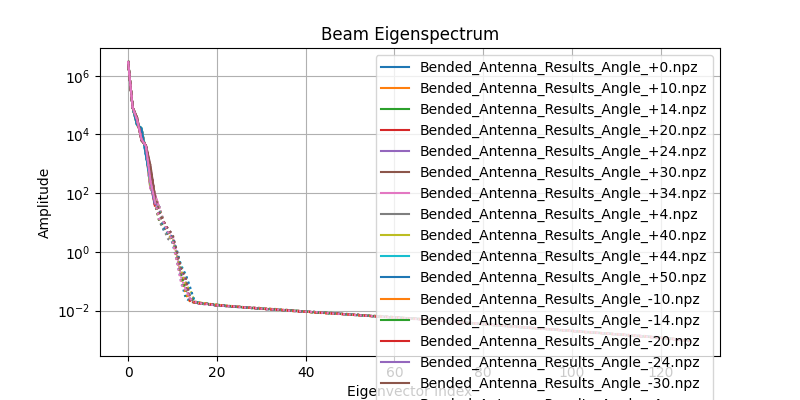

In [13]:
plt.figure(figsize=(8, 4))
for i in range(nbeams):
    line, = plt.semilogy(S[i], ':')
    plt.semilogy(S[i,:idx[i]], color=line.get_color(), label=filenames[i])
plt.grid()
plt.title('Beam Eigenspectrum')
plt.xlabel('Eigenvector index')
plt.ylabel('Amplitude')
plt.legend(loc='best')
None

(256, 512)


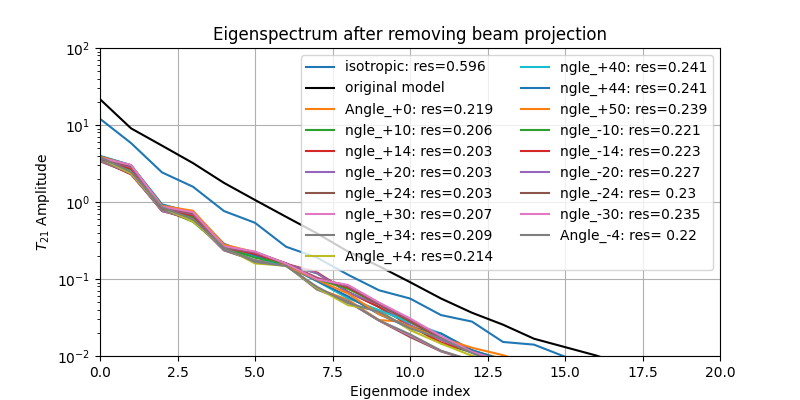

In [19]:
Tsky = np.random.uniform(180, 400, size=256)[:, None] * (freqs[None, :] / 180e6)**np.random.uniform(-2.6, -2.4, size=256)[:, None]
print(Tsky.shape)
_U, _S, _V = np.linalg.svd(Tsky)
_idx = _S.size - np.searchsorted(_S[::-1], _S[0] / 1e5)

_T21cm = T21cm - np.mean(T21cm, axis=0, keepdims=True)

plt.figure(figsize=(8,4))
_T21cm_p = _T21cm - (_T21cm @ (_V[:_idx].conj().T)) @ _V[:_idx]
_residual = np.linalg.norm(_T21cm_p, axis=1) / np.linalg.norm(_T21cm, axis=1)
_S21cm_p = np.linalg.svd(_T21cm_p)[1]
plt.semilogy(_S21cm_p, label=f'isotropic: res={np.mean(_residual):5.3}')

S21cm = np.linalg.svd(_T21cm)[1]
plt.semilogy(S21cm, 'k', label='original model')
for i in range(nbeams):
    # project out T21cm components that match beam
    T21cm_p = _T21cm - (_T21cm @ (V[i,:idx[i]].conj().T)) @ V[i,:idx[i]]
    residual = np.linalg.norm(T21cm_p, axis=1) / np.linalg.norm(_T21cm, axis=1)
    S21cm_p = np.linalg.svd(T21cm_p)[1]
    plt.semilogy(S21cm_p, label=f'{filenames[i][-12:-4]}: res={np.mean(residual):5.3}')
plt.legend(ncol=2, loc='best')
plt.ylim(1e-2, 1e2)
plt.xlim(0, 20)
plt.ylabel('$T_{21}$ Amplitude')
plt.xlabel('Eigenmode index')
plt.title('Eigenspectrum after removing beam projection')
plt.grid()
None

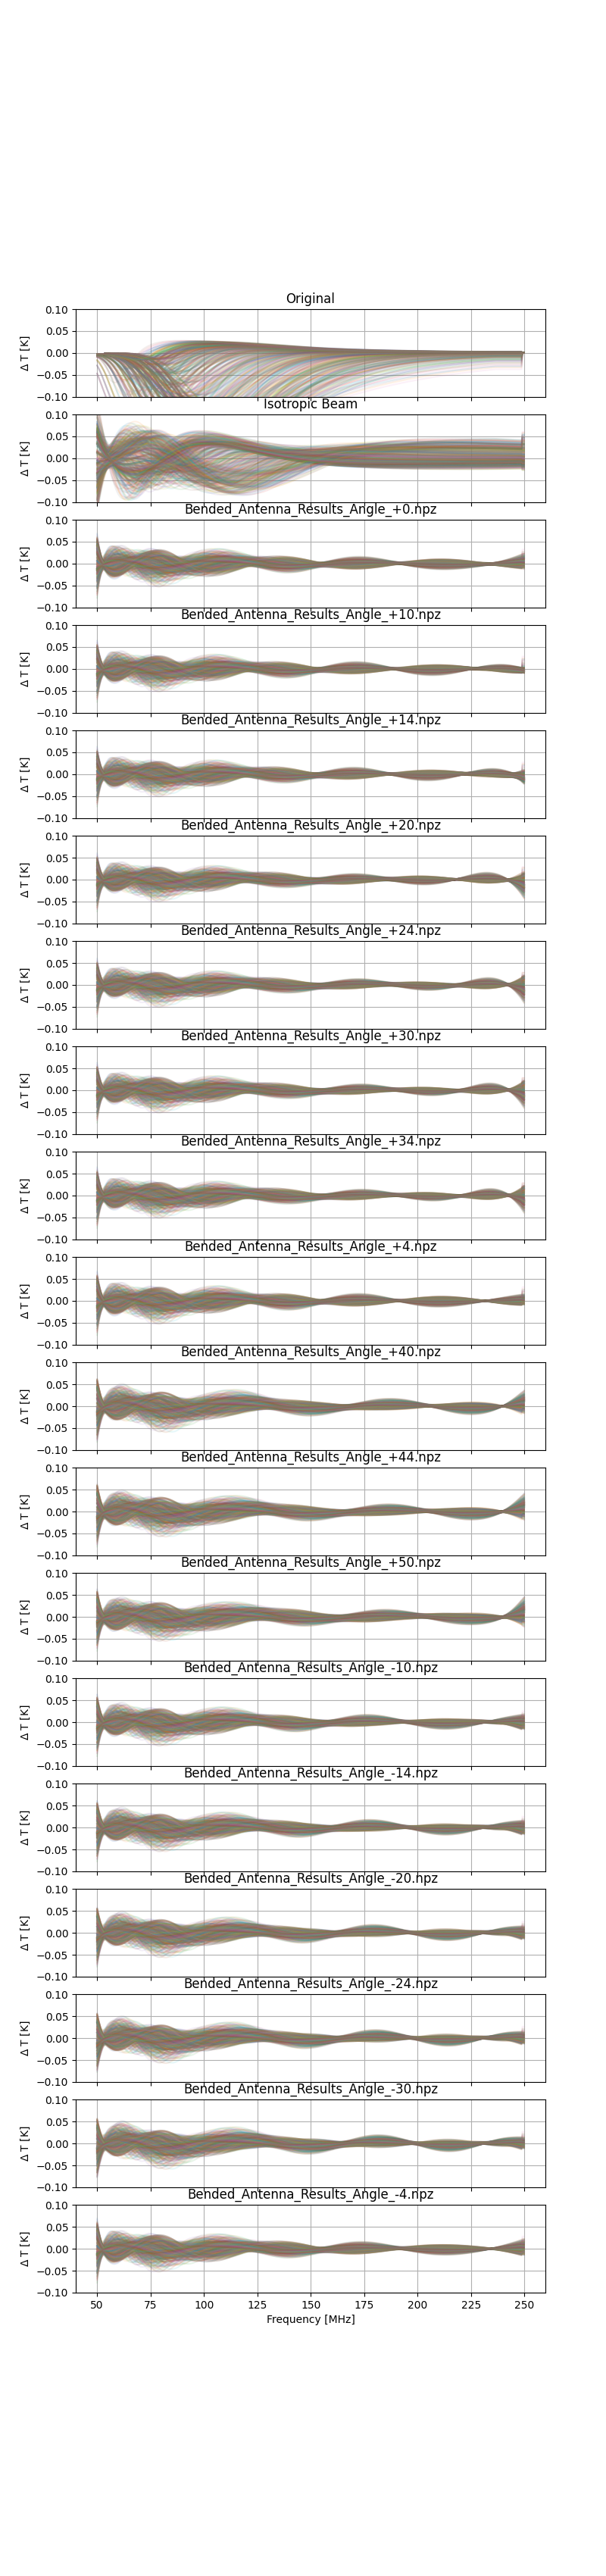

In [15]:
fig, axes = plt.subplots(nrows=nbeams+2, sharex=True, sharey=True, figsize=(8,2*nbeams))
axes[0].plot(freqs / 1e6, T21cm.T, alpha=0.1)
axes[0].set_title('Original')
axes[1].set_title('Isotropic Beam')
axes[1].plot(freqs / 1e6, _T21cm_p.T, alpha=0.1)
for i in range(nbeams):
    T21cm_p = T21cm - (T21cm @ (V[i,:idx[i]].conj().T)) @ V[i,:idx[i]]
    axes[i+2].plot(freqs / 1e6, T21cm_p.T, alpha=0.1)
    axes[i+2].set_title(filenames[i])
for ax in axes:
    ax.set_ylabel('$\Delta$ T [K]')
    ax.set_ylim(-0.1, 0.1)
    ax.grid()
axes[-1].set_xlabel('Frequency [MHz]')
None